<a href="https://colab.research.google.com/github/YoNeIzeR/SRC-Challenge-Group-14/blob/master/Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import get_file
from keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import numpy as np



Using TensorFlow backend.


In [0]:
batch_size = 32
# 5 types of flowers
num_classes = 5
# training for 10 epochs
epochs = 4
# size of each image
IMAGE_SHAPE = (224, 224, 3)

In [0]:
import matplotlib.pyplot as plt


In [0]:
%matplotlib inline

In [0]:
def load_data():
    """This function downloads, extracts, loads, normalizes and one-hot encodes Flower Photos dataset"""
    # download the dataset and extract it
    data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
    data_dir = pathlib.Path(data_dir)
    # count how many images are there
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Number of images:", image_count)
    # get all classes for this dataset (types of flowers) excluding LICENSE file
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    # roses = list(data_dir.glob('roses/*'))
    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen, CLASS_NAMES

In [0]:
def create_model(input_shape):
    # load MobileNetV2
    model = MobileNetV2(input_shape=input_shape)
    # remove the last fully connected layer
    model.layers.pop()
    # freeze all the weights of the model except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    # construct our own fully connected layer for classification
    output = Dense(num_classes, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
    model.summary()
    # training the model using rmsprop optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [0]:
def create_model(input_shape):
    # load MobileNetV2
    model = MobileNetV2(input_shape=input_shape)
    # remove the last fully connected layer
    model.layers.pop()
    # freeze all the weights of the model except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    # construct our own fully connected layer for classification
    output = Dense(num_classes, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
    model.summary()
    # training the model using rmsprop optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [6]:
if __name__ == "__main__":
    # load the data generators
    train_generator, validation_generator, class_names = load_data()
    # constructs the model
    model = create_model(input_shape=IMAGE_SHAPE)
    # model name
    model_name = "MobileNetV2_finetune_last5"
    # some nice callbacks
    tensorboard = TensorBoard(log_dir=f"logs/{model_name}")
    checkpoint = ModelCheckpoint(f"results/{model_name}" + "-loss-{val_loss:.2f}-acc-{val_acc:.2f}.h5",
                                save_best_only=True,
                                verbose=1)
    # make sure results folder exist
    if not os.path.isdir("results"):
        os.mkdir("results")
    # count number of steps per epoch
    training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
    validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
    # train using the generators
    model.fit_generator(train_generator, steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, verbose=1, callbacks=[tensorboard, checkpoint])

228818944/228813984 [==============================] - 2s 0us/step
Number of images: 3670
Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.











14540800/14536120 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
_________________________________________

KeyboardInterrupt: ignored

In [10]:
# load the data generators
train_generator, validation_generator, class_names = load_data()
# constructs the model
model = create_model(input_shape=IMAGE_SHAPE)
# load the optimal weights
model.load_weights("results/MobileNetV2_finetune_last5_less_lr-loss-0.45-acc-0.86.h5")
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
# print the validation loss & accuracy
evaluation = model.evaluate_generator(validation_generator, steps=validation_steps_per_epoch, verbose=1)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1])

Number of images: 3670
Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]         

OSError: ignored

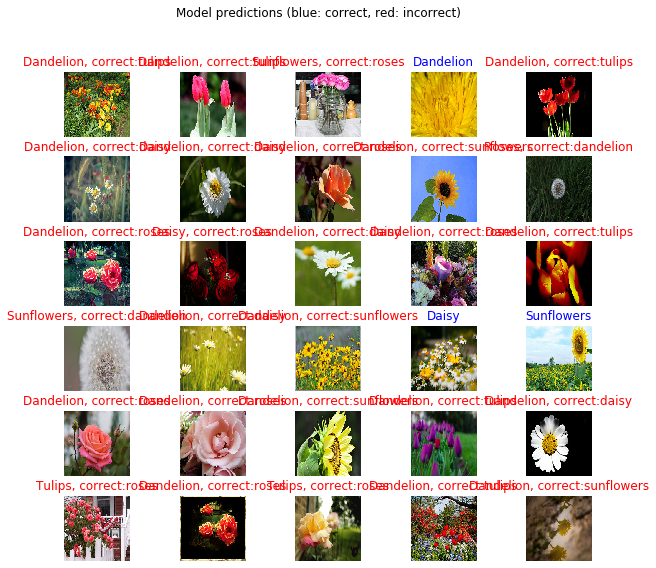

In [14]:
# get a random batch of images
image_batch, label_batch = next(iter(validation_generator))
# turn the original labels into human-readable text
label_batch = [class_names[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()